## Sanity test model

This notebook generates synthetic data to sanity test whether our GPT1 model can learn a simple task: Predict
the next integer in a sequence of integers, where the next element in the sequence is simply the previous element + 1.

In [ ]:
import torch
from bettmensch_ai_examples.gpt_1.src.model import GPT1Pretrain
from bettmensch_ai_examples.gpt_1.src.train import GPT1PretrainConfig, GPT1Trainer
torch.autocast

W0224 21:35:19.249000 22912 torch\distributed\elastic\multiprocessing\redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\scher\Repositories\bettmensch.ai-examples\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pipeline pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Base Component pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Base Component pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Pipeline pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Base Component pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Base Component pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Pipeline pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Base Component pipeline context: <bettmensch_ai.pipelines.pipeline_context.PipelineContext object at 0x0000026C506B7990>
Base Component pipeline context: <bettmensch_ai.pi

In [2]:
config_test = GPT1PretrainConfig.from_file("C:\\Users\\scher\\Repositories\\bettmensch.ai-examples\\sdk\\bettmensch_ai_examples\\gpt_1\\src\\config_test.yaml")
print(config_test.data)
print(config_test.tokenizer)
print(config_test.model)
print(config_test.trainer)

{'train': {'path': 'tokenized_data_validation', 'dataloader': {'batch_size': 45, 'shuffle': True}}, 'validation': {'use': False, 'path': 'tokenized_data_validation', 'dataloader': {'batch_size': 50, 'shuffle': False}}}
{'path': 'tokenizer_train'}
{'architecture': {'n_tokens': 10, 'dim_embed': 20, 'n_decoder_layers': 1, 'n_heads': 2, 'dropout': 0.1}, 'misc': {'verbose': False}}
{'optimizer': {'lr': 0.00025, 'weight_decay': 0.01, 'eps': 0.001}, 'training': {'n_epochs': 3, 'n_batches': 500, 'display_step': 5}}


In [3]:
N_VOCAB = 1500

model_test = GPT1Pretrain(n_vocab=N_VOCAB,**config_test.model['architecture'])
model_test

GPT1Pretrain(
  (embedding): Embedding(
    (token): Embedding(1500, 20)
    (pos): Embedding(10, 20)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (skip_norm_mha): SkipNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (skipped_layer): MultiHeadedSelfAttention(
            (projection_attention): Linear(in_features=20, out_features=60, bias=True)
            (dropout_attention): Dropout(p=0.1, inplace=False)
            (projection_out): Linear(in_features=20, out_features=20, bias=True)
            (dropout_residual): Dropout(p=0.1, inplace=False)
          )
          (norm_layer): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        )
        (skip_norm_ff): SkipNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (skipped_layer): FeedForward(
            (sequential): Sequential(
              (0): Linear(in_features=20, out_features=3072, bias=True)
          

In [7]:
nps = [(pn,p) for pn,p in model_test.named_parameters()]
nps

[('embedding.token.weight',
  Parameter containing:
  tensor([[-0.7180, -0.5825, -0.2787,  ..., -1.6495,  0.8708,  1.8398],
          [-0.1912,  0.2254,  2.1083,  ...,  0.5257,  0.3815,  1.6363],
          [-0.4771,  0.4988,  1.2965,  ...,  0.1214,  0.7768,  1.5773],
          ...,
          [-1.6998,  0.6437, -1.6535,  ..., -0.2487,  2.2689, -0.7052],
          [-1.1328,  1.3095,  0.8377,  ..., -0.0312, -0.4390,  0.3985],
          [ 0.8773, -0.5692, -1.6326,  ..., -0.5892, -1.0592, -0.4315]],
         requires_grad=True)),
 ('embedding.pos.weight',
  Parameter containing:
  tensor([[-7.9954e-01, -5.0730e-01, -1.9956e-02,  9.0666e-01,  1.6411e+00,
            1.5456e+00,  1.1292e+00, -7.5348e-01, -4.7715e-01,  1.2364e-01,
            6.4902e-01, -1.3958e+00,  1.1651e+00, -1.4263e+00,  1.5661e+00,
            1.1361e+00,  1.5043e+00, -3.2815e-01, -2.0203e-01,  1.7076e-01],
          [-1.0491e+00, -1.3843e+00, -6.1726e-01, -2.2661e+00, -7.2461e-01,
           -9.5075e-01,  1.1640e+00,  

In [10]:
nps[0][1].dtype

torch.float32

In [74]:
from typing import List, Tuple
from jaxtyping import Float
import random

class TestDataSet(torch.utils.data.Dataset):
    """A synthetic data set consisting of sequences of sequential integers, i.e.
    input, target pairs ~ ([3,4,5,6,...,(n_tokens-1)],[4,5,6,...,(n_tokens-2)])
    to be used to sanity check transformer implementation.
    """
    def __init__(self, n: int = 1000,  n_vocab: int = 100, n_tokens: int = 10):

        self.token_data = self.generate_data(n=n,n_vocab=n_vocab,n_tokens=n_tokens)

    def __len__(self) -> int:
        return len(self.token_data)

    def __getitem__(self, idx) -> List[int]:
        return self.token_data[idx]
    
    def generate_data(self,n: int, n_vocab: int, n_tokens: int) -> List[List[int]]:
        data = []
        for i in range(n):
            sequence_start = random.choice(range(n_vocab-n_tokens))
            data.append([token for token in range(sequence_start, sequence_start+n_tokens+1)])

        return data
    
    @staticmethod
    def collate_batch(token_samples: List[List[int]]) -> Tuple[
        Float[torch.Tensor, "n_batch n_tokens"],
        Float[torch.Tensor, "n_batch n_tokens"],
        Float[torch.Tensor, "n_batch n_tokens"],
    ]:
        
        inputs_list = [torch.tensor(token_sample[:-1], dtype=torch.int64) for token_sample in token_samples]
        inputs_tensor = torch.stack(inputs_list)

        mask_tensor = torch.ones(inputs_tensor.size(),dtype=torch.bool)

        target_list = [torch.tensor(token_sample[1:], dtype=torch.int64) for token_sample in token_samples]
        target_tensor = torch.stack(target_list)

        return inputs_tensor, mask_tensor, target_tensor

In [75]:
data_test = TestDataSet(n=int(0.9 * N_VOCAB),n_vocab=N_VOCAB,n_tokens=config_test.model['architecture']['n_tokens'])
data_test.token_data
# ~ [[11, 12, 13, 14, 15, 16],
#  [7, 8, 9, 10, 11, 12],
#  [10, 11, 12, 13, 14, 15],
#  [14, 15, 16, 17, 18, 19],
#  [9, 10, 11, 12, 13, 14],
#  [14, 15, 16, 17, 18, 19],
#  [5, 6, 7, 8, 9, 10],
#  [8, 9, 10, 11, 12, 13],
#  [14, 15, 16, 17, 18, 19],
#  [13, 14, 15, 16, 17, 18]]

[[1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026],
 [1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133],
 [608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618],
 [700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710],
 [1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466],
 [1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336],
 [259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805],
 [1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441],
 [1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129],
 [620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630],
 [1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140],
 [736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746],
 [1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469],
 [1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 149

In [76]:
import torch.utils
import torch.utils.data

optimizer_test = torch.optim.AdamW(model_test.parameters(),**config_test.trainer['optimizer'])
data_loader_test = torch.utils.data.DataLoader(data_test, collate_fn=data_test.collate_batch, batch_size=2,shuffle=True)

In [77]:
for inputs, mask, targets in iter(data_loader_test):
    print(f"inputs: {inputs}")
    print(f"targets: {targets}")
    print(f"mask: {mask}")

inputs: tensor([[ 846,  847,  848,  849,  850,  851,  852,  853,  854,  855],
        [1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081]])
targets: tensor([[ 847,  848,  849,  850,  851,  852,  853,  854,  855,  856],
        [1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082]])
mask: tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])
inputs: tensor([[ 503,  504,  505,  506,  507,  508,  509,  510,  511,  512],
        [1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]])
targets: tensor([[ 504,  505,  506,  507,  508,  509,  510,  511,  512,  513],
        [1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024]])
mask: tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])
inputs: tensor([[486, 487, 488, 489, 490, 491, 492, 493, 494, 495],
        [109, 110, 111, 112, 113, 114, 1

In [79]:
N_EPOCHS = 100
STEP = 50
step_loss = 0
step_losses = []
model_test.train()

for i_epoch in range(N_EPOCHS):
    for i_batch, (inputs, mask, targets) in enumerate(data_loader_test):
        model_test.zero_grad()

        logits, loss = model_test(inputs,mask,targets)
        loss.backward()
        step_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model_test.parameters(),max_norm=1)

        optimizer_test.step()
        if i_batch % STEP == 0:
            print(f"Step loss for epoch{i_epoch} and batch {i_batch}: {step_loss / STEP}")
            step_losses.append(step_loss / STEP)
            step_loss = 0


Step loss for epoch0 and batch 0: 0.05219235897064209
Step loss for epoch0 and batch 50: 2.4479931139945985
Step loss for epoch0 and batch 100: 2.5040633940696715
Step loss for epoch0 and batch 150: 2.418974561691284
Step loss for epoch0 and batch 200: 2.5608391416072847
Step loss for epoch0 and batch 250: 2.306839883327484
Step loss for epoch0 and batch 300: 2.4494806838035585
Step loss for epoch0 and batch 350: 2.3609222269058225
Step loss for epoch0 and batch 400: 2.2716278982162477
Step loss for epoch0 and batch 450: 2.5003429293632506
Step loss for epoch0 and batch 500: 2.588327851295471
Step loss for epoch0 and batch 550: 2.5492020201683045
Step loss for epoch0 and batch 600: 2.3747320437431334
Step loss for epoch0 and batch 650: 2.4161001348495486
Step loss for epoch1 and batch 0: 1.2239286613464355
Step loss for epoch1 and batch 50: 2.4022326111793517
Step loss for epoch1 and batch 100: 2.1837631916999816
Step loss for epoch1 and batch 150: 2.315053424835205
Step loss for epoch

In [ ]:
train_data_starts = sorted(list(set([record[0] for record in iter(data_test.token_data)])))
train_data_starts

[0,
 1,
 2,
 5,
 6,
 9,
 10,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 32,
 35,
 37,
 39,
 42,
 43,
 44,
 46,
 47,
 49,
 52,
 55,
 56,
 57,
 58,
 59,
 60,
 63,
 64,
 66,
 67,
 68,
 69,
 71,
 73,
 75,
 76,
 77,
 80,
 81,
 85,
 87,
 89,
 91,
 93,
 94,
 99,
 100,
 103,
 104,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 122,
 124,
 125,
 126,
 132,
 133,
 134,
 138,
 139,
 141,
 144,
 145,
 150,
 151,
 153,
 154,
 155,
 156,
 159,
 161,
 162,
 163,
 164,
 166,
 168,
 169,
 170,
 171,
 173,
 175,
 177,
 179,
 180,
 181,
 185,
 186,
 188,
 191,
 192,
 194,
 195,
 198,
 201,
 204,
 206,
 208,
 209,
 210,
 211,
 212,
 215,
 216,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 230,
 231,
 234,
 235,
 236,
 237,
 240,
 245,
 246,
 248,
 250,
 252,
 253,
 255,
 258,
 259,
 261,
 262,
 263,
 264,
 265,
 266,
 269,
 270,
 271,
 272,
 273,
 274,
 279,
 281,
 285,
 286,
 288,
 289,
 290,
 291,
 292,
 295,
 296,
 297,
 298,
 300,
 302,
 304,
 305

In [85]:
validation_data_starts = [i for i in range(N_VOCAB) if i not in train_data_starts]
len(validation_data_starts), validation_data_starts

(614,
 [3,
  4,
  7,
  8,
  11,
  13,
  27,
  30,
  31,
  33,
  34,
  36,
  38,
  40,
  41,
  45,
  48,
  50,
  51,
  53,
  54,
  61,
  62,
  65,
  70,
  72,
  74,
  78,
  79,
  82,
  83,
  84,
  86,
  88,
  90,
  92,
  95,
  96,
  97,
  98,
  101,
  102,
  105,
  106,
  117,
  118,
  119,
  120,
  121,
  123,
  127,
  128,
  129,
  130,
  131,
  135,
  136,
  137,
  140,
  142,
  143,
  146,
  147,
  148,
  149,
  152,
  157,
  158,
  160,
  165,
  167,
  172,
  174,
  176,
  178,
  182,
  183,
  184,
  187,
  189,
  190,
  193,
  196,
  197,
  199,
  200,
  202,
  203,
  205,
  207,
  213,
  214,
  217,
  218,
  219,
  220,
  229,
  232,
  233,
  238,
  239,
  241,
  242,
  243,
  244,
  247,
  249,
  251,
  254,
  256,
  257,
  260,
  267,
  268,
  275,
  276,
  277,
  278,
  280,
  282,
  283,
  284,
  287,
  293,
  294,
  299,
  301,
  303,
  308,
  310,
  311,
  312,
  314,
  315,
  320,
  327,
  329,
  330,
  332,
  333,
  337,
  339,
  341,
  342,
  343,
  346,
  347,
  348,
  

In [116]:
validation_sample_index = 500
validation_sample_start = validation_data_starts[validation_sample_index]
validation_input = [i for i in range(validation_sample_start,validation_sample_start+10)]
print(validation_input)

[1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225]


In [117]:
model_test.eval()
logits, _ = model_test(x=torch.tensor([validation_input],dtype=torch.int),mask=torch.tensor([[True,]*10],dtype=torch.bool))
logits.size()

torch.Size([1, 10, 1500])

In [118]:
predicted_integers = logits.max(-1)
predicted_integers

torch.return_types.max(
values=tensor([[21.8489, 20.5295, 20.3453, 19.5581, 20.0903, 20.4160, 20.2260, 18.9267,
         17.6620, 21.6586]], grad_fn=<MaxBackward0>),
indices=tensor([[1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226]]))

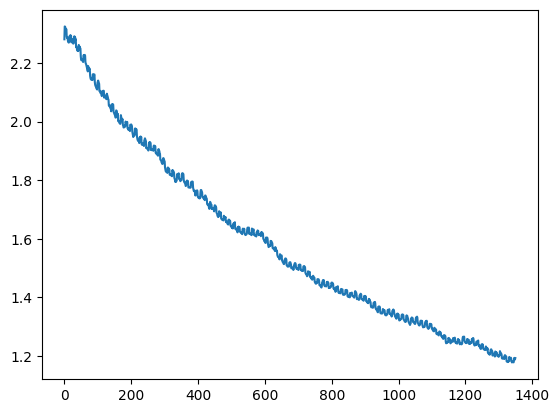

In [112]:
from matplotlib import pyplot as plt
window_size = 50
averaged_step_losses = [sum(step_losses[i:i+window_size])/window_size for i in range(len(step_losses)-window_size)]
plt.plot(range(len(step_losses)-window_size),averaged_step_losses)
plt.show()

In [111]:
len(step_losses)

1400